In [1049]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import integrate as sinteg

import integrated_bispectrum

import integrated_bispectrum_vec_general

from NumbaQuadpack import quadpack_sig, dqags
import numba as nb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1573]:
import bispectrum_3D_numba as b3n
import interpolated_quantities_numba as iqn

In [1550]:
%timeit integrated_bispectrum.bispectrum_matter(1, 1, 1, np.pi/3, np.pi/3, np.pi/3, 1, model = 'TR')

61.1 µs ± 5.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [1570]:
b3n.bispectrum_matter_TR(1, 1, 1, np.pi/3, np.pi/3, np.pi/3, 1, model = 'TR')

248790.50270500773

In [1592]:
%timeit b3n.bispectrum_matter_TR(1, 1, 1, np.pi/3, np.pi/3, np.pi/3, 1)

1.3 µs ± 6.88 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
def bispectrum_at_ells_of_chi(chi, data): 
        return chi**(-4)*iqn.Wkk(chi)**3*b3n.bispectrum_matter(l/chi, l/chi, l/chi, angle, angle, angle, iqn.zofchi(chi))

In [1651]:
@np.vectorize
def integrate_bispectrum_kkk(l1, l2, l3, angle12, angle13, angle23, model = 'TR'):
    bispectrum_at_ells_of_chi = lambda chi: chi**(-4)*integrated_bispectrum.Wkk(chi)**3*integrated_bispectrum.bispectrum_matter(l1/chi, l2/chi, l3/chi, angle12, angle13, angle23, integrated_bispectrum.zofchi(chi), model = model)
    #return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 50, rtol = 1e-8)[0]
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 2, miniter = 1, rtol = 1e-12)[0]

In [1652]:
%timeit integrate_bispectrum_kkk(1, 1, 1, np.pi/3, np.pi/3, np.pi/3, model = 'TR')

433 µs ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1646]:
#@np.vectorize
#@jit
def integrate_bispectrum_kkk_prova(l_, angle_):
    @nb.cfunc(quadpack_sig)
    def bispectrum_at_ells_of_chi(chi, data_): 
        data = nb.carray(data_, (2,))
        l, angle = data[0], data[1]
        return chi**(-4)*iqn.Wkk(chi)**3*b3n.bispectrum_matter_TR(l/chi, l/chi, l/chi, angle, angle, angle, iqn.zofchi(chi))
    funcptr = bispectrum_at_ells_of_chi.address
    data = np.array([l_, angle_], dtype = np.float64)
    sol, abserr, success = dqags(funcptr, 0, integrated_bispectrum.chistar, data = data, epsabs = 1e-1, epsrel = 1e-1)
    return sol #sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 50, rtol = 1e-8)[0]

In [1686]:
integrated_bispectrum.chistar

13858.934986501856

In [1740]:
@np.vectorize
def integrate_bispectrum_kkk_prova_2(l, angle):
    @np.vectorize
    def bispectrum_at_ells_of_chi(chi): 
        return chi**(-4)*iqn.Wkk(chi)**3*b3n.bispectrum_matter_TR(l/chi, l/chi, l/chi, angle, angle, angle, iqn.zofchi(chi))
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, miniter = 10, maxiter = 50, rtol = 1e-8)[0]

In [1745]:
#get points and weights for Gaussian quadrature using numpy legendre module
def gaussxw(a, b, N):
    x, w = np.polynomial.legendre.leggauss(N)
    return 0.5*(b-a)*x + 0.5*(b+a), 0.5*(b-a)*w



In [1768]:
xs, ws = gaussxw(0, integrated_bispectrum.chistar, 10)

In [1779]:
xs, ws = gaussxw(0, b3n.chistar, 10)

@np.vectorize
def integrate_bispectrum_kkk_TR_gauss(l1, l2, l3, angle12, angle13, angle23):
    @np.vectorize
    def bispectrum_at_ells_of_chi(chi): 
        return chi**(-4)*iqn.Wkk(chi)**3*b3n.bispectrum_matter_TR(l1/chi, l2/chi, l3/chi, angle12, angle13, angle23, iqn.zofchi(chi))
    return np.dot(bispectrum_at_ells_of_chi(xs), ws)

def get_angle_12(L1, L2, L3):
    term = (L1**2+L2**2-L3**2)/(2*L1*L2)
    return np.arccos(term)

@jit
def integrate_bispectrum_kkk_TR_gauss_from_triangle(l1, l2, l3):
    def bispectrum_at_ells_of_chi(chi): 
        angle12, angle13, angle23 = get_angle_12(l1, l2, l3), get_angle_12(l1, l3, l2), get_angle_12(l2, l3, l1)
        return chi**(-4)*iqn.Wkk(chi)**3*b3n.bispectrum_matter_TR(l1/chi, l2/chi, l3/chi, angle12, angle13, angle23, iqn.zofchi(chi))
    return np.dot(bispectrum_at_ells_of_chi(xs, l1, l2, l3), ws)

In [1781]:
def get_angle_cos12(L1, L2, L3):
    return (L1**2+L2**2-L3**2)/(2*L1*L2)
%timeit get_angle_cos12(3, 4, 5)

640 ns ± 11 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [1780]:
integrate_bispectrum_kkk_TR_gauss_from_triangle(3, 4, 5)

TypingError: Failed in object mode pipeline (step: convert make_function into JIT functions)
[1mCannot capture the non-constant value associated with variable 'l1' in a function that will escape.
[1m
File "../../../../../../var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_68835/1941456660.py", line 17:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

In [1771]:
@np.vectorize
def integrate_bispectrum_kkk_prova_gauss(l, angle):
    @np.vectorize
    def bispectrum_at_ells_of_chi(chi): 
        return chi**(-4)*iqn.Wkk(chi)**3*b3n.bispectrum_matter_TR(l/chi, l/chi, l/chi, angle, angle, angle, iqn.zofchi(chi))
    return np.dot(bispectrum_at_ells_of_chi(xs), ws)

In [1772]:
%timeit integrate_bispectrum_kkk_prova_gauss(100, np.pi/3)

92.9 µs ± 2.24 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [1743]:
@np.vectorize
def integrate_bispectrum_kkk_prova_3(l, angle):
    @np.vectorize
    def bispectrum_at_ells_of_chi(chi): 
        return chi**(-4)*iqn.Wkk(chi)**3*b3n.bispectrum_matter_TR(l/chi, l/chi, l/chi, angle, angle, angle, iqn.zofchi(chi))
    return sinteg.fixed_quad(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, n = 10)[0]
    #return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, miniter = 10, maxiter = 50, rtol = 1e-8)[0]

In [1744]:
integrate_bispectrum_kkk_prova_2(100, np.pi/3)/integrate_bispectrum_kkk_prova_3(100, np.pi/3)

0.9900840114937858

In [1767]:
integrate_bispectrum_kkk_prova_gauss(100, np.pi/3)/integrate_bispectrum_kkk_prova_2(100, np.pi/3)

0.9270836018936137

In [1774]:
%timeit integrate_bispectrum_kkk_prova_2(100, np.pi/3)

216 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1753]:
%timeit integrate_bispectrum_kkk_prova_3(100, np.pi/3)

104 µs ± 117 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
#@np.vectorize
#@jit
def integrate_bispectrum_kkk_prova(l_, angle_):
    @nb.cfunc(quadpack_sig)
    def bispectrum_at_ells_of_chi(chi, data_): 
        data = nb.carray(data_, (2,))
        l, angle = data[0], data[1]
        return chi**(-4)*iqn.Wkk(chi)**3*b3n.bispectrum_matter_TR(l/chi, l/chi, l/chi, angle, angle, angle, iqn.zofchi(chi))
    funcptr = bispectrum_at_ells_of_chi.address
    data = np.array([l_, angle_], dtype = np.float64)
    sol, abserr, success = dqags(funcptr, 0, integrated_bispectrum.chistar, data = data, epsabs = 1e-1, epsrel = 1e-1)
    return sol #sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 50, rtol = 1e-8)[0]

In [1735]:
%timeit iqn.zofchi(precomputed_chis)

4.88 µs ± 70.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [1669]:
@nb.njit
def integrate_bispectrum_kkk_alt_(l_, angle_):
    @np.vectorize(excluded=['l', 'angle'])
    def bispectrum_at_ells_of_chi(chi, l, angle): 
        return chi**(-4)*iqn.Wkk(chi)**3*b3n.bispectrum_matter_TR(l/chi, l/chi, l/chi, angle, angle, angle, iqn.zofchi(chi))
    return integrate_numba(bispectrum_at_ells_of_chi(precomputed_chis, l, angle), precomputed_chis)

In [1715]:
def integrate_bispectrum_kkk_prova(l_, angle_):
    @nb.cfunc(quadpack_sig)
    def bispectrum_at_ells_of_chi(chi, data_): 
        data = nb.carray(data_, (2,))
        l, angle = data[0], data[1]
        return chi**(-4)#*iqn.Wkk(chi)**3*b3n.bispectrum_matter_TR(l/chi, l/chi, l/chi, angle, angle, angle, iqn.zofchi(chi))
    funcptr = bispectrum_at_ells_of_chi.address
    data = np.array([l_, angle_], dtype = np.float64)
    sol, abserr, success = dqags(funcptr, 0, integrated_bispectrum.chistar, data = data, epsabs = 1, epsrel = 1)
    return sol #sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 50, rtol = 1e-8)[0]

In [1727]:
@nb.cfunc(quadpack_sig)
def f(chi, data):
    return chi**-4*iqn.Wkk(chi)**3
funcptr = f.address

a = 0
b = integrated_bispectrum.chistar

In [1728]:
%timeit sol, abserr, success = dqags(funcptr, a, b)

18.1 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [1726]:
def ff(chi):
    return chi**-4*iqn.Wkk(chi)**3
%timeit sinteg.quadrature(ff, a, b)

20.8 µs ± 437 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [1713]:
integrate_bispectrum_kkk_prova(100., np.pi/3)

1.5655939787716132e-13

In [1678]:
integrate_bispectrum_kkk_prova_2(100., np.pi/3)

array(1.58120502e-13)

In [1716]:
%timeit integrate_bispectrum_kkk_prova(100, np.pi/3)

20.2 ms ± 779 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1690]:
%timeit integrate_bispectrum_kkk_prova_2(100, np.pi/3)

219 µs ± 5.63 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1701]:
@nb.cfunc(quadpack_sig)
def f(x, data_):
    data = nb.carray(data_, (2,))
    return np.sum(data)*x**2
funcptr = f.address
a = 0
b = 1000
data = np.array([1.0,2.0],np.float64)

In [1702]:
def ff(x):
    return x**2

In [1703]:
%timeit sol, abserr, success = dqags(funcptr, a, b, data = data)

898 ns ± 8.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [1704]:
%timeit sinteg.quadrature(ff, a, b)

20.6 µs ± 153 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [2]:
#https://github.com/toshiyan/cmblensplus/blob/dcd212906da8039f63839d69e8bb45ebccd55d09/F90/src_utils/bstool.f90#L988
def W3j_approx(l1,l2,l3):
  #ind = np.where((l1+l2+l3)%2 != 0)
  if (l1+l2+l3)%2 != 0:
    result = 0
  else:
    Lh = (l1+l2+l3)*0.5
    a1 = ((Lh-l1+0.5)/(Lh-l1+1))**(Lh-l1+0.25)
    a2 = ((Lh-l2+0.5)/(Lh-l2+1))**(Lh-l2+0.25)
    a3 = ((Lh-l3+0.5)/(Lh-l3+1))**(Lh-l3+0.25)
    b = 1/((Lh-l1+1)*(Lh-l2+1)*(Lh-l3+1))**(0.25)
    result = (-1)**Lh/np.sqrt(2*np.pi) * np.exp(1.5)* (Lh+1)**(-0.25) * a1*a2*a3*b
  #result[ind] = 0
  return result

In [3]:
@np.vectorize
def geom_factor(l1, l2, l3):
    result = np.sqrt((2*l1+1)*(2*l2+1)*(2*l3+1)/(4*np.pi))
    result *= W3j_approx(l1, l2, l3)
    return result


In [27]:
%timeit integrated_bispectrum.zofchi(precomputed_chis)

7.33 µs ± 63.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [60]:
chi_precalculated, z_precalculated = np.loadtxt("products/zs.txt", unpack = True)

In [72]:
chi_kk, Wkk = np.loadtxt("products/Wkk.txt", unpack = True)

In [130]:
from numba import jit

@jit
def zofchi_numba(newchis):
    return np.interp(newchis, chi_precalculated, z_precalculated)

@jit
def Wkk_numba(newchis):
    return np.interp(newchis, chi_kk, Wkk)

@jit
def integrate_numba(y, x):
    return np.trapz(y, x)



In [131]:
integrate_numba(np.arange(0., 10., 1), np.arange(0., 10., 1))

40.5

In [68]:
%timeit zofchi_numba(np.arange(0., 1000., 1))

7.6 µs ± 26 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [69]:
%timeit zofchi_numba(np.linspace(0, 400, 1000))

17.3 µs ± 156 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [70]:
%timeit np.interp(np.linspace(0, 400, 1000), chi, z)

22.6 µs ± 847 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [1052]:
@np.vectorize
def integrate_bispectrum_kkk_prova(l, angle, model = 'TR'):
    @nb.cfunc(quadpack_sig)
    def bispectrum_at_ells_of_chi(chi, data): 
        return chi**(-4)*integrated_bispectrum.Wkk(chi)**3*integrated_bispectrum.bispectrum_matter(l/chi, l/chi, l/chi, angle, angle, angle, integrated_bispectrum.zofchi(chi), model = model)
    funcptr = bispectrum_at_ells_of_chi.address
    sol, abserr, success = dqags(funcptr, 0, integrated_bispectrum.chistar)
    return sol #sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 50, rtol = 1e-8)[0]

In [1119]:
P2D = np.loadtxt("products/matterpower_P.txt", unpack = True)
k = np.loadtxt("products/matterpower_k.txt", unpack = True)
z = np.loadtxt("products/matterpower_z.txt", unpack = True)

In [1120]:
logz = np.log10(z)
logk = np.log10(k)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_68835/181510802.py:1: RuntimeWarning: divide by zero encountered in log10
  logz = np.log10(z)


In [1133]:
np.log10(P2D).shape

(1000, 1001)

In [1134]:
logz.shape

(1001,)

Error is: 4.53e-06


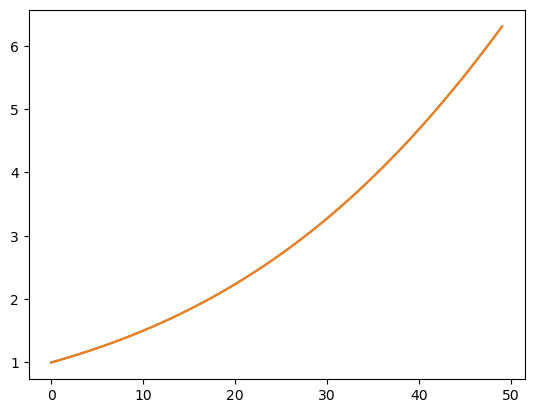

In [1171]:
nx = 50
ny = 37
xv, xh = np.linspace(0, 1,       nx, endpoint=True,  retstep=True)
yv, yh = np.linspace(0, 2*np.pi, ny, endpoint=False, retstep=True)
x, y = np.meshgrid(xv, yv, indexing='ij')

test_function = lambda x, y: np.exp(x)*np.exp(np.sin(y))
f = test_function(x, y)

test_x = -xh/2.0
test_y = 271.43
fa = test_function(test_x, test_y)

interpolater = fast_interp.interp2d([0,0], [1,2*np.pi], [xh,yh], f, k=5, p=[False,True], e=[1,0])
fe = interpolater(test_x, test_y)

plt.plot(interpolater(xv, xv))
plt.plot(test_function(xv, xv))


print('Error is: {:0.2e}'.format(np.abs(fe-fa)))

In [1152]:
xv.shape

(50,)

In [1279]:
import fast_interp

interpolated = fast_interp.interp2d([logz[1:].min(), logk.min()], [logz[1:].max(), logk.max()], [round(logz[3]-logz[2], 4), round(logk[3]-logk[2], 4)], (P2D)[1:, :].T, k = 5, p = [False, False], c = [False, False], e = [True, True])


In [1526]:
zgrid = np.loadtxt('products/neff_z.txt')
ksneff = np.loadtxt('products/neff_k.txt')
neff2D = np.loadtxt('products/neff.txt')

In [1530]:
neff2Dinterp = scipy.interpolate.RectBivariateSpline(zgrid, ksneff, neff2D)
neff2Dinterpf = lambda z, k: neff2Dinterp(z, k, grid = False)

In [1539]:
from interpolation.splines import UCGrid, nodes
from interpolation.splines import eval_linear
from interpolation.splines import extrap_options as xto

functions = [lambda z, k: integrated_bispectrum.PK.P(z, k, grid = False), lambda z, k: integrated_bispectrum.PKlin.P(z, k, grid = False), lambda z, k: neff2Dinterp(z, k, grid = False)]
name = ["non_lin", "lin", "neff"]
for name, function in zip(name, functions):
    grid = UCGrid((-12., logz.max(), 1000), (logk.min(), logk.max(), 1000))
    gp = nodes(grid)
    N = int(np.sqrt(gp.shape[0]))
    values = function(10**gp[:,0], 10**gp[:,1]).reshape((N, N))
    np.savetxt(f"numbaproducts/{name}_matter_power.txt", values)

np.savetxt("numbaproducts/z_k_matter_powers.txt", gp)

In [1547]:
grid

((-12.0, 3.0, 1000), (-5.0, 2.0, 1000))

In [1519]:
zfake, kfake = np.log10(np.logspace(-3, 3, 1000)), np.log10(np.logspace(-3, 2, 1000))
points = np.array([zfake, kfake]).T

In [1520]:
val = eval_linear(grid, values, points, xto.NEAREST)

In [1513]:
%timeit val = eval_linear(grid, values, points)

3.42 µs ± 6.09 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [1514]:
%timeit integrated_bispectrum.P(10**zfake, 10**kfake, grid = False)

175 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [1515]:
%timeit eval_linear_numba(grid, values, points)

3.34 µs ± 15.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [1507]:
@jit(nopython=True)
def eval_linear_numba(grid, values, points):
    return eval_linear(grid, values, points)

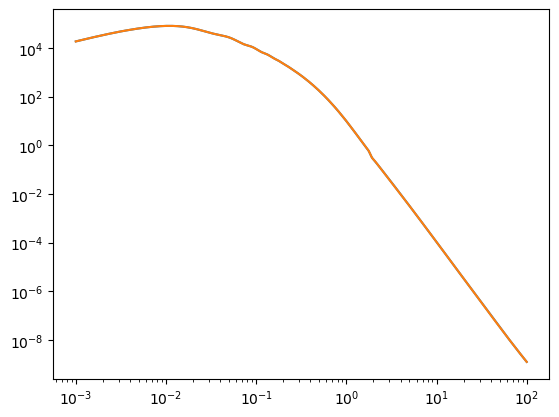

In [1521]:
plt.loglog(10**kfake, val)
plt.semilogy(10**kfake, integrated_bispectrum.P(10**zfake, 10**kfake, grid = False))

In [1299]:
%timeit integrated_bispectrum.P(z[10:100], k[10:100], grid = False)

9.61 µs ± 41.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [1301]:
%timeit interp2d(z[10:100], k[10:100], z, k, P2D.T)

236 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1313]:
@jit(nopython=True)
def function(zz, kk):
    return interp2d(zz, kk, z, k, P2D.T)

In [1314]:
zz, kk = z[10:100], k[10:100]

In [1317]:
%timeit function(zz, kk)

243 µs ± 2.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1302]:
interp2d(z[10:100], k[10:100], z, k, P2D.T).shape

(90,)

In [1294]:
interp2d(np.array([2, 1]), np.array([5, 1]), z, k, P2D.T)

array([  5.30380963, 179.59485392])

In [1280]:
interpolate2d_Rect_Scipy = scipy.interpolate.RectBivariateSpline(logk, logz[1:], P2D[:, 1:].T)

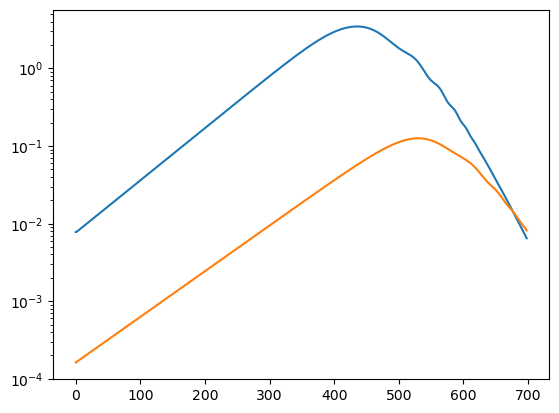

In [1282]:
ksin = np.log10(k[1:700])
zsin = np.log10(200)*np.ones_like(ksin)
plt.semilogy((interpolated(zsin, ksin)))
plt.plot(interpolate2d_Rect_Scipy(zsin, ksin, grid = False))

In [4]:
@np.vectorize
def integrate_bispectrum_kkk(l1, l2, l3, angle12, angle13, angle23, model = 'TR'):
    bispectrum_at_ells_of_chi = lambda chi: chi**(-4)*integrated_bispectrum.Wkk(chi)**3*integrated_bispectrum.bispectrum_matter(l1/chi, l2/chi, l3/chi, angle12, angle13, angle23, integrated_bispectrum.zofchi(chi), model = model)
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 50, rtol = 1e-8)[0]

In [102]:
zofchi_numba(1)

0.00022351546572828087

In [157]:
from scipy.integrate import simpson
import itertools

Note: redshifts have been re-sorted (earliest first)


/Users/omard/Documents/projects/fgcmblensing/bispectrum/integrated_bispectrum.py:244: RuntimeWarning: divide by zero encountered in divide
  


In [183]:
%timeit integrated_bispectrum.bispectrum_matter(k1, k2, k3, theta12, theta13, theta23, z)

59.9 µs ± 376 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [179]:
%timeit integrated_bispectrum.F2ptker_vector(k1, k2, theta12, z)

13.8 µs ± 56.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [236]:
rng = np.random.default_rng()

In [241]:
np.trapz(pdf, precomputed_chis)

1.0000000000000002

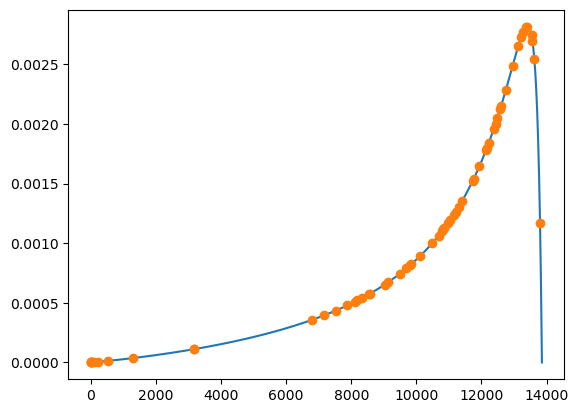

In [1058]:
precomputed_chis = np.linspace(1e-10, integrated_bispectrum.chistar/1e3, 10000)
precomputed_chis = np.append(precomputed_chis, np.linspace(integrated_bispectrum.chistar/1e3, integrated_bispectrum.chistar/2, 100))
precomputed_chis = np.append(precomputed_chis, np.linspace(integrated_bispectrum.chistar/2, integrated_bispectrum.chistar*3/4, 100))
precomputed_chis = np.append(precomputed_chis, np.linspace(integrated_bispectrum.chistar*3/4, integrated_bispectrum.chistar, 120))
norm = np.trapz(Wkk_numba(precomputed_chis), precomputed_chis)

plt.plot(precomputed_chis, Wkk_numba(precomputed_chis))

pdf = Wkk_numba(precomputed_chis)/norm
pdf /= pdf.sum()
#choose random chis
chis = rng.choice(precomputed_chis, size = 50, p = pdf, replace = False)
chis = np.sort(chis)
chis = np.append(np.logspace(1e-10, np.log10(chis.min()), 10), chis)
plt.plot(chis, Wkk_numba(chis), 'o')
#plt.plot(precomputed_chis, integrated_bispectrum.Wkk(precomputed_chis))

In [1684]:
@np.vectorize
def integrate_bispectrum_kkk(l1, l2, l3, angle12, angle13, angle23, model = 'TR'):
    bispectrum_at_ells_of_chi = lambda chi: chi**(-4)*integrated_bispectrum.Wkk(chi)**3*integrated_bispectrum.bispectrum_matter(l1/chi, l2/chi, l3/chi, angle12, angle13, angle23, integrated_bispectrum.zofchi(chi), model = model)
    #return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 50, rtol = 1e-8)[0]
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 100, miniter = 50, rtol = 1e-12)[0]

In [1542]:
np.savetxt("numbaproducts/precomputed_dchis.txt", np.c_[precomputed_chis, dchis])

In [1059]:
dchis = (chis[2:]-chis[:-2])/2
precomputed_chis = chis[1:-1]

def integrate_bispectrum_kkk_alt_(l1, l2, l3, angle12, angle13, angle23, model = 'TR'):
    bispectrum_at_ells_of_chi = lambda chi: chi**(-4)*Wkk_numba(chi)**3*integrated_bispectrum.bispectrum_matter(l1/chi, l2/chi, l3/chi, angle12, angle13, angle23, zofchi_numba(chi), model = model)
    #value = bispectrum_at_ells_of_chi(precomputed_chis)
    return integrate_numba(bispectrum_at_ells_of_chi(precomputed_chis), precomputed_chis)
    #return simpson(value, precomputed_chis)
    #return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 50, rtol = 1e-8)[0]
    #return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 50, rtol = 1e-8)[0]
    #return np.dot(dchis, bispectrum_at_ells_of_chi(precomputed_chis))
integrate_bispectrum_kkk_alt = np.vectorize(integrate_bispectrum_kkk_alt_, excluded = ['model'])

%timeit integrate_bispectrum_kkk_alt(1, 1, 1, np.pi/3, np.pi/3, np.pi/3, model = 'TR')


277 µs ± 4.92 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [512]:
integrate_bispectrum_kkk_alt(1, 1, 1, np.pi/3, np.pi/3, np.pi/3, model = 'TR')/integrate_bispectrum_kkk(1, 1, 1, np.pi/3, np.pi/3, np.pi/3, model = 'TR')

1.1802988410151742

In [391]:
integrate_bispectrum_kkk(1, 1, 1, np.pi/3, np.pi/3, np.pi/3, model = 'TR')

array(6.39148569e-15)

In [392]:
integrate_bispectrum_kkk_alt(1, 1, 1, np.pi/3, np.pi/3, np.pi/3, model = 'TR')/integrate_bispectrum_kkk(1, 1, 1, np.pi/3, np.pi/3, np.pi/3, model = 'TR')

0.9999951952987476

In [490]:
%timeit integrate_bispectrum_kkk_alt(1, 1, 1, np.pi/3, np.pi/3, np.pi/3, model = 'TR')

352 µs ± 6.46 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [491]:
%timeit integrate_bispectrum_kkk(1, 1, 1, np.pi/3, np.pi/3, np.pi/3, model = 'TR')

591 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [88]:
bispectrum_at_ells_of_chi = lambda l1, l2, l3, angle12, angle13, angle23, chi, model: chi**(-4)*integrated_bispectrum.Wkk(chi)**3*integrated_bispectrum.bispectrum_matter(l1/chi, l2/chi, l3/chi, angle12, angle13, angle23, integrated_bispectrum.zofchi(chi), model = model)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_68835/2716358792.py:5: RuntimeWarning: divide by zero encountered in divide
  calculated = 8/(ls**3)**2*integrate_bispectrum_kkk(ls, ls, ls, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_68835/2716358792.py:6: RuntimeWarning: divide by zero encountered in divide
  calculated_alt = 8/(ls**3)**2*integrate_bispectrum_kkk_prova_gauss(ls, np.pi/3)#integrate_bispectrum_kkk_alt(ls, ls, ls, angle12, angle13, angle23, model = model)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_68835/2716358792.py:7: RuntimeWarning: invalid value encountered in multiply
  p = plt.plot(ls, calculated*ls**6, label = model)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_68835/2716358792.py:8: RuntimeWarning: invalid value encountered in multiply
  plt.plot(ls, calculated_alt*ls**6, label = model + ' alt', color = p[0].get_color(), 

Text(0.5, 0, '$L$')

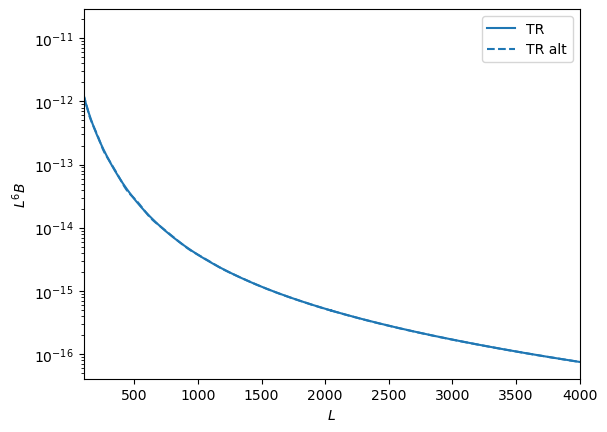

In [1773]:
ls = np.arange(1, 4000)
models = ['TR']
for model in models:
    angle12, angle13, angle23 = np.pi/3, np.pi/3, np.pi/3
    calculated = 8/(ls**3)**2*integrate_bispectrum_kkk(ls, ls, ls, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
    calculated_alt = 8/(ls**3)**2*integrate_bispectrum_kkk_prova_gauss(ls, np.pi/3)#integrate_bispectrum_kkk_alt(ls, ls, ls, angle12, angle13, angle23, model = model)
    p = plt.plot(ls, calculated*ls**6, label = model)
    plt.plot(ls, calculated_alt*ls**6, label = model + ' alt', color = p[0].get_color(), linestyle = '--')
#plt.xscale('log')
plt.yscale('log')
plt.xlim(100, 4000)
plt.legend()
plt.ylabel('$L^6B$')
plt.xlabel('$L$')

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_68835/4239412873.py:5: RuntimeWarning: divide by zero encountered in divide
  calculated = 8/(ls**3)**2*integrate_bispectrum_kkk(ls, ls, ls, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_68835/4239412873.py:6: RuntimeWarning: divide by zero encountered in divide
  calculated_alt = 8/(ls**3)**2*integrate_bispectrum_kkk_alt(ls, ls, ls, angle12, angle13, angle23, model = model)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_68835/4239412873.py:7: RuntimeWarning: invalid value encountered in divide
  p = plt.plot(ls, calculated/calculated_alt, label = model)


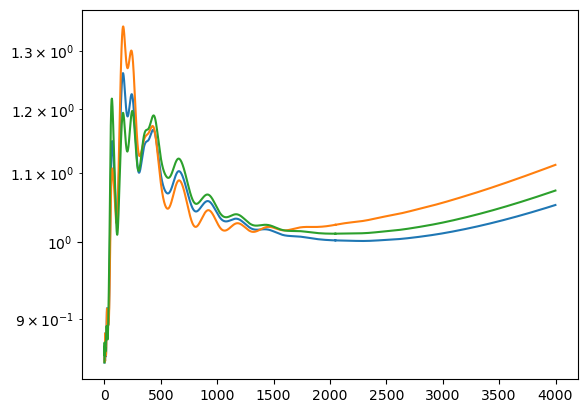

In [1048]:
ls = np.arange(1, 4000)
models = ['TR', 'GM', 'SC']
for model in models:
    angle12, angle13, angle23 = np.pi/3, np.pi/3, np.pi/3
    calculated = 8/(ls**3)**2*integrate_bispectrum_kkk(ls, ls, ls, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
    calculated_alt = 8/(ls**3)**2*integrate_bispectrum_kkk_alt(ls, ls, ls, angle12, angle13, angle23, model = model)
    p = plt.plot(ls, calculated/calculated_alt, label = model)
    #plt.plot(ls, calculated_alt*ls**6, label = model + ' alt', color = p[0].get_color(), linestyle = '--')
#plt.xscale('log')
plt.yscale('log')

In [516]:
import vegas

lmin, lmax = 1, 4000

integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi], [lmin, lmax], [0, 2*np.pi]])
nitn, neval = 10, 1e2

values = []

def get_angle_12(L1, L2, L3):
    term = (L1**2+L2**2-L3**2)/(2*L1*L2)
    return np.arccos(term)

Rs = np.linspace(0.1, 6, 10)

Rdeg = R/60
Rradians = np.deg2rad(Rdeg)
sigma = Rradians / (2.0 * np.sqrt(2.0 * np.log(2.0)))
WR = lambda l: np.exp(-(l*(l+1))/2*sigma**2)

models = ['TR', 'GM', 'SC']
results = {}
for model in models:
    values = []
    for R in Rs:

        Rdeg = R/60
        Rradians = np.deg2rad(Rdeg)
        sigma = Rradians / (2.0 * np.sqrt(2.0 * np.log(2.0)))
        WR = lambda l: np.exp(-(l*(l+1))/2*sigma**2)
        #WR = lambda l: np.exp(-l**2*Rradians**2/2)

        @vegas.batchintegrand
        def integrand(x):
            l, thetal = x[:, 0], x[:, 1]
            L, thetaL = x[:, 2], x[:, 3]

            lx, ly = np.cos(thetal)*l, np.sin(thetal)*l
            Lplx = L*np.cos(thetaL)+lx
            Lply = L*np.sin(thetaL)+ly
            Lplv = np.array([Lplx, Lply])
            Lpl = np.linalg.norm(Lplv, axis = 0)
            angle12 = get_angle_12(l, L, Lpl)
            angle13 = get_angle_12(l, Lpl, L)
            angle23 = get_angle_12(L, Lpl, l)
            value = L*l*WR(L)*WR(l)*WR(Lpl)*integrate_bispectrum_kkk_alt(l, L, Lpl, angle12, angle13, angle23, model = model)
            return value/(2*np.pi)**2/(2*np.pi)**2

        result = integ(integrand, nitn = nitn, neval = neval)
        values += [result.mean]
        
    Rs, values = np.array(Rs), np.array(values)
    results[model] = values

In [517]:
results_sims = np.load('results.npy', allow_pickle = True).take(0)
results_G_Born = np.load('resultsG.npy', allow_pickle = True).take(0)

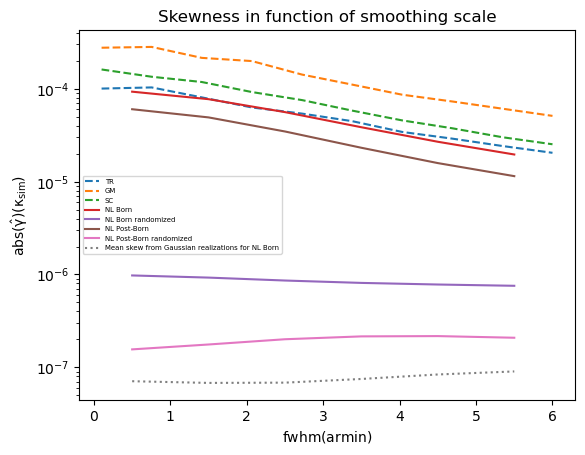

In [518]:
for k, values in results.items():
    plt.plot(Rs, abs(values), label = k, ls = '--')

fwhms = np.arange(0.5, 6, 1.)
plt.title('Skewness in function of smoothing scale')
for k in results_sims.keys():
    skews = np.array(results_sims[k])
    plt.plot(fwhms, abs(skews), label = k)

N = 2
meanskew = 0
for i in range(N):
    meanskew += np.array(results_G_Born[i])
meanskew /= N
plt.plot(fwhms, abs(meanskew), label = 'Mean skew from Gaussian realizations for NL Born', ls = ':')

plt.ylabel(r'$\rm{abs}(\hat{\gamma})(\kappa_{\rm{sim}})$')
plt.xlabel(r'$\rm{fwhm} (armin)$')

#plt.hlines(-1e-6, 0.5, 6, color = 'k', ls = '--', label = '-1e-6 line', alpha = 0.4)
plt.yscale('log')
plt.legend(fontsize = 5)
plt.savefig('empirical_skew_demuni.png', dpi = 300)

## Calculating $N^{3/2,\mathrm{cross}}$

In [953]:
import camb
import symlens as s
from pixell import enmap, utils as putils
import numpy as np

TCMB = 2.73e6

potential_file = "lensedCMB_dmn1_lenspotentialCls.dat"
d = np.loadtxt(f'/Users/omard/Documents/projects/fgcmblensing/input/giulio/{potential_file}')
l = d[:, 0]
lfact = 2*np.pi/l/(l+1)
unlensed = d[:, 1]
unlensed *= lfact**2#/TCMB**2.
ddlensing = d[:, 5]
kk = 2*np.pi*ddlensing/4
pp = 4/l**2/(l+1)**2*kk

TCMB = 2.73e6

dd = np.loadtxt('/Users/omard/Documents/projects/fgcmblensing/input/giulio/lensedCMB_dmn1_lensedgradCls.dat')

d = np.loadtxt('/Users/omard/Documents/projects/fgcmblensing/input/giulio/lensedCMB_dmn1_lensedCls.dat')
L, TT = d[:, 0], d[:, 1]
lensed = d[:, 1]
lfact = 2*np.pi/L/(L+1)
TT *= lfact#/TCMB**2.
lensed *= lfact

unlensed = np.interp(L, l, unlensed)



get_noise = lambda x, level, theta: (level*np.pi/180/60)**2*np.exp(x*(x+1)*np.deg2rad(theta / 60)**2/8/np.log(2))

shape,wcs = enmap.geometry(shape=(512,512),res=2.0*putils.arcmin,pos=(0,0))

modlmap = enmap.modlmap(shape,wcs)

f = s.Ldl1 * s.e('uC_T_T_l1') + s.Ldl2 * s.e('uC_T_T_l2')

F = f / 2 / s.e('tC_T_T_l1') / s.e('tC_T_T_l2')

expr1 = f * F

fsky = 0.4
noise, beam = 1., 1.

feed_dict = {}
feed_dict['uC_T_T'] = s.interp(L,TT)(modlmap)
feed_dict['tC_T_T'] = s.interp(L,TT)(modlmap)+s.interp(L,get_noise(L, noise, beam))(modlmap)

tellmin = 10
tellmax = 3000
xmask = s.mask_kspace(shape,wcs,lmin=tellmin,lmax=tellmax)
integral = s.integrate(shape,wcs,feed_dict,expr1,xmask=xmask,ymask=xmask).real
Alkappa = modlmap**4*1/integral/4

AlkappaR = s.A_l(shape,wcs,feed_dict,"hu_ok","TT",xmask=xmask,ymask=xmask)

bin_edges = np.arange(1,4000,20)
binner = s.bin2D(modlmap,bin_edges)
A_l = Alkappa

cents, ALR1D = binner.bin(AlkappaR)

cents, AL1D = binner.bin(A_l)

Nl = s.N_l_from_A_l_optimal(shape,wcs,AlkappaR)
cents, Nl1D = binner.bin(Nl)

expr = integral
cents, expr1D = binner.bin(expr)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_68835/2565879204.py:56: RuntimeWarning: invalid value encountered in divide
  Alkappa = modlmap**4*1/integral/4
/Users/omard/Documents/projects/symlens/symlens/utils.py:170: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]
/Users/omard/Documents/projects/symlens/symlens/qe.py:748: RuntimeWarning: overflow encountered in multiply
  return Al * modlmap*(modlmap+1.)/4.
/Users/omard/Documents/projects/symlens/symlens/utils.py:170: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [954]:
Alphi = expr1D**-1

In [955]:
lmin, lmax = tellmin, tellmax
selection = (L >= lmin) & (L <= lmax)

In [956]:
unlensed_for_interp = unlensed.copy()
unlensed_for_interp[~selection] = 0

In [957]:
#from scipy.interpolate import InterpolatedUnivariateSpline

In [958]:
import scipy as sp

uTT = sp.interpolate.InterpolatedUnivariateSpline(L, unlensed_for_interp)#, fill_value = 0., bounds_error = False)
lTT = sp.interpolate.InterpolatedUnivariateSpline(L[selection], lensed[selection])#, fill_value = 0., bounds_error = False)
tTT = sp.interpolate.InterpolatedUnivariateSpline(L[selection], lensed[selection]+get_noise(L, noise, beam)[selection])#, fill_value = 1e20, bounds_error = False)

In [959]:
import scipy as sp

uTT = sp.interpolate.interp1d(L[selection], unlensed[selection], fill_value = 0., bounds_error = False)
lTT = sp.interpolate.interp1d(L[selection], lensed[selection], fill_value = 0., bounds_error = False)
tTT = sp.interpolate.interp1d(L[selection], lensed[selection]+get_noise(L, noise, beam)[selection], fill_value = 1e20, bounds_error = False)

In [994]:
def dot(a, b):
    return np.einsum('abc, abc -> bc', a, b)

def fTT(l1v, l2v, l1n, l2n):
    return dot(l1v+l2v, l1v)*lTT(l1n)+dot(l1v+l2v, l2v)*lTT(l2n)

def ftotTT(l):
    return tTT(l)

def filters(ells):
    return (ells>=lmin) & (ells<=lmax)

def gTT(lv, Lv, lvnorm):
    l1v, l2v = lv, Lv-lv
    l1n, l2n = lvnorm, np.linalg.norm(l2v, axis = 0)
    return fTT(l1v, l2v, l1n, l2n)/(2*ftotTT(l1n)*ftotTT(l2n))#*filters(l1n)*filters(l2n)

In [1040]:
LLs = np.arange(1, 4000, 5)
lls = np.arange(1, 4000, 5)
thetals = np.linspace(1e-4, 2*np.pi-1e-4, 200)

ls, thetas = np.meshgrid(lls, thetals, indexing = 'ij')
lx = ls*np.cos(thetas)
costhetas = np.cos(thetas)

for L_ in LLs:
    
    Lv = np.ones_like(ls)*L_
    
    Ldotl = Lv*lx
    
    L_l = Lv**2+ls**2-2*Ldotl
    L_l = np.sqrt(L_l)

    L_dot_L_l = -Lv**2.+Ldotl
    l_dot_L_l = -ls**2.+Ldotl

    integrate_bispectrum_kkk_alt(L1mod, L2mod, L3mod, thet12, thet23, thet13, model = "TR")


In [1037]:
thetas.shape

(800, 200)

In [1033]:
thetals.shape

(1,)

In [1032]:
thetas.shape

(1, 800)

In [1031]:
ls.shape

(1, 800)

In [1028]:
costhetas[0]

array([1.])

In [1025]:
Ldotl[0]

0.999999995

In [1010]:
def prodfTot(l1n, l2n):
    return ftotTT(l1n)*ftotTT(l2n)
vprod = prodfTot(l1smesh, l2smesh)
interprodfTot = sp.interpolate.RectBivariateSpline(l1s, l2s, vprod)

(3199, 3199)

In [1041]:
nthetas = 100
nrs = 1000
theta = np.linspace(0, 2*np.pi, nthetas)
r = np.linspace(lmin, lmax, nrs)
R, T = np.meshgrid(r, theta, indexing = 'ij')

In [1042]:
lv = np.array([R * np.cos(T), R * np.sin(T)])

In [1043]:
def integrand(R, T, Lv, g):
    lv = np.array([R * np.cos(T), R * np.sin(T)])
    return g(lv, Lv[:, None, None], R)

def get_polar_integral(g):
    def polar_integral(Lv, lmin, lmax, nthetas = 100, nrs = 1000, epstheta = 1e-4):
        theta = np.linspace(0+epstheta, 2*np.pi-epstheta, nthetas)
        r = np.linspace(lmin, lmax, nrs)
        R, T = np.meshgrid(r, theta, indexing = 'ij')
        integrand_values = integrand(R, T, Lv, g) * R
        result = np.einsum('ij->', integrand_values) * ((lmax-lmin) / nrs) * ((2*np.pi-2*epstheta) / nthetas)
        return result
    return polar_integral

In [1044]:

def get_function(lext):
    def function(lv, Lv, lvnorm):
        resultA = gTT(lv, Lv, lvnorm)
        diff = lext-lv
        diffnorm = np.linalg.norm(diff, axis = 0)
        resultB = uTT(diffnorm)#*filters(diffnorm)
        diff_dot_lext = dot(diff, lext)
        diff_L = Lv-lext
        diff_dot_diff_L = dot(diff, diff_L)
        return resultA * resultB * diff_dot_lext * diff_dot_diff_L
    return function

In [1045]:
def get_angle_12(L1, L2, L3):
    term = (L1**2+L2**2-L3**2)/(2*L1*L2)
    return np.nan_to_num(np.arccos(term))

In [1046]:
def integrand_ext(lext, R, Lv, lmin, lmax, nthetas, nrs):
    result = np.zeros_like(R)
    for i in range(nrs):
        for j in range(nthetas):
            l_ = lext[:, i, j]
            f = get_function(l_[:, None, None])
            polar_integrals = get_polar_integral(f)
            result[i, j] = polar_integrals(Lv, lmin, lmax, nthetas, nrs)
    return result

In [992]:
def polar_integral_ext(integrand_ext, Lv, lmin, lmax, nthetas = 100, nrs = 100, epstheta = 1e-3):
    theta = np.linspace(0+epstheta, 2*np.pi-epstheta, nthetas)
    r = np.linspace(lmin, lmax, nrs)
    Rext, Text = np.meshgrid(r, theta, indexing = 'ij')
    lext = np.array([Rext * np.cos(Text), Rext * np.sin(Text)])
    integrand_values = integrand_ext(lext, Rext, Lv, lmin, lmax, nthetas, nrs) * Rext
    L1 = Lv[:, None, None]
    L2 = lext
    L3 = L1-lext
    L1mod = Lv[0]
    L2mod = Rext
    L3mod = np.linalg.norm(L3, axis = 0)
    thet12, thet23, thet13 = get_angle_12(L1mod, L2mod, L3mod), get_angle_12(L2mod, L3mod, L1mod), get_angle_12(L3mod, L1mod, L2mod)
    #print('Shape', integrate_bispectrum_kkk_alt(L1mod, L2mod, L3mod, thet12, thet23, thet13, model = "TR").shape)
    bispectrum_term = 8/(L1mod*(L1mod+1)*L2mod*(L2mod+1)*L3mod*(L3mod+1))*integrate_bispectrum_kkk_alt(L1mod, L2mod, L3mod, thet12, thet23, thet13, model = "TR")
    integrand_values *= bispectrum_term
    result = np.einsum('ij->', integrand_values) * ((lmax-lmin) / nrs) * ((2*np.pi-2*epstheta) / nthetas)
    return result/(2.*np.pi)**2/(2.*np.pi)**2

In [ ]:
integrate_bispectrum_kkk_alt(L1mod, L2mod, L3mod, thet12, thet23, thet13, model = "TR")

In [995]:
%timeit polar_integral_ext(integrand_ext, np.array([200, 0]), lmin, lmax, nthetas = 20, nrs = 20)


65.3 ms ± 727 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [988]:
-polar_integral_ext(integrand_ext, np.array([200, 0]), lmin, lmax, nthetas = 200, nrs = 200)


0.00020246481436939586

In [989]:
-polar_integral_ext(integrand_ext, np.array([200, 0]), lmin, lmax, nthetas = 400, nrs = 400)


Process SpawnPoolWorker-23:
Process SpawnPoolWorker-22:
Process SpawnPoolWorker-21:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cmban

KeyboardInterrupt: 

In [987]:
-polar_integral_ext(integrand_ext, np.array([200, 0]), lmin, lmax, nthetas = 80, nrs = 80)


0.0008083460881641134

In [969]:
from joblib import Parallel, delayed

In [970]:
batch_size = 5
n_jobs = 4
backend = "threading"

In [971]:
def do(LL):
    Lv = np.array([LL, 0])
    return -polar_integral_ext(integrand_ext, Lv, lmin, lmax, nthetas = 80, nrs = 100)*np.interp(LL, cents, Alphi)


In [972]:
Llist = np.linspace(50, 2000, 20)

In [973]:
results = Parallel(n_jobs = n_jobs, batch_size = batch_size, backend=backend, verbose=0)(delayed(do)(LL) for LL in Llist)

In [974]:
results = np.array(results)

In [975]:
selection = results<0

In [976]:
negativeresults = results.copy()
negativeresults[~selection] = np.nan

positiveresults = results.copy()
positiveresults[selection] = np.nan

(50, 4000)

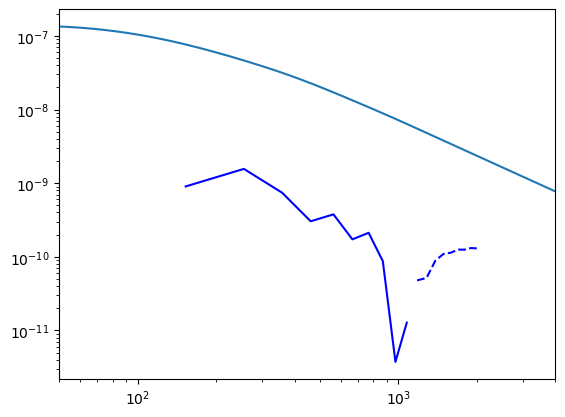

In [977]:
plt.loglog(Llist, (positiveresults)*Llist**4/2/np.pi, color = 'b')
plt.loglog(Llist, (-negativeresults)*Llist**4/2/np.pi, ls = '--', color = 'b')

#plt.loglog(Llist, abs(results)*Llist**4/2/np.pi, color = 'b')


plt.plot(l, pp*l**4/2/np.pi)
plt.xlim(50, 4000)

(100.0, 4000.0)

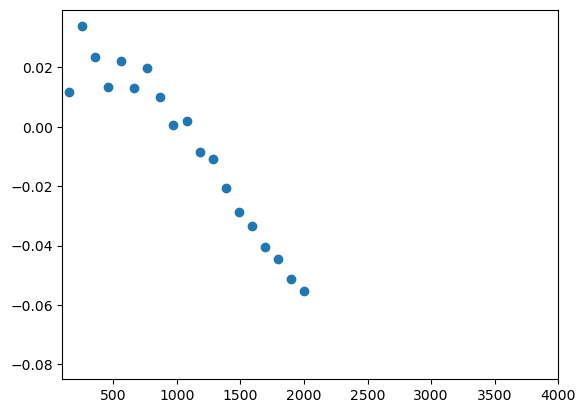

In [980]:
plt.plot(Llist, (results)/np.interp(Llist, l, pp), 'o')
plt.xlim(100, 4000)

In [481]:
Ls = np.arange(5, 1000, 10)

In [482]:
import vegas

lmin, lmax = 1, 4000

integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi]])
nitn, neval = 10, 1e2
    

In [483]:
Rs = {}
names = ['par', 'perp']
result_temps = {n: [] for n in names}
for L in Ls:
    Lvec = np.array([L, 0])
    def integrand(x):
            l, theta = x 
            common = g(np.array([l*np.cos(theta), l*np.sin(theta)]), Lvec)*uTT(l)*l**2*l
            return [common*f(theta)**2 for f in [np.cos, np.sin]]
    result = integ(integrand, nitn = nitn, neval = neval)
    [result_temps[n].append(result[i].mean) for i, n in enumerate(names)]
Rs = {n: np.array(result_temps[n])/(2*np.pi)**2 for n in names}

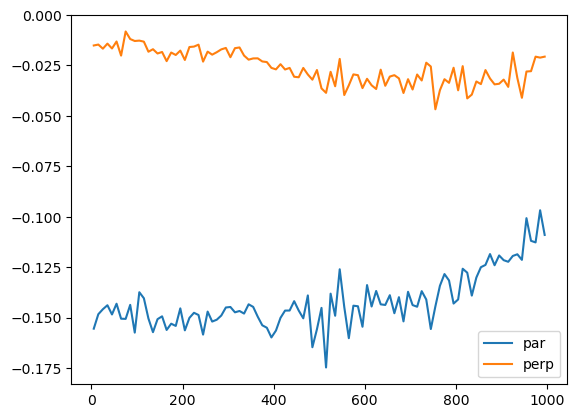

In [484]:
for n in names:
    plt.plot(Ls, Rs[n]*1/Ls**2*1e-11, label = n)
plt.legend()

In [485]:
model = 'TR'

In [486]:
lmin, lmax = 1, 4000
integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi]])
nitn, neval = 10, 1e2

In [487]:
betas = {}
bparf = lambda l, theta, L: np.cos(theta)*(l*np.cos(theta)-L)*l
bperpf = lambda l, theta, L: np.sin(theta)**2*l**2


result_temps = {n: [] for n in names}
for L in Ls:
    Lvec = np.array([L, 0])

    def integrand(x):
        l, theta = x
        Lmlv = np.array([L-l*np.cos(theta), -l*np.sin(theta)])
        Lml = np.linalg.norm(Lmlv)
        angle12 = get_angle_12(l, -L, Lml)
        angle13 = get_angle_12(l, Lml, -L)
        angle23 = get_angle_12(-L, Lml, l)
        angle12, angle13, angle23 = np.nan_to_num(angle12), np.nan_to_num(angle13), np.nan_to_num(angle23)
        factortophi = -8/(l*L*Lml)**2
        common = factortophi*integrate_bispectrum_kkk(l, Lml, L, angle12, angle13, angle23, model = model)*l
        return [f(l, theta, L)*common for f in [bparf, bperpf]]

    result = integ(integrand, nitn = nitn, neval = neval)
    [result_temps[n].append(result[i].mean) for i, n in enumerate(names)]
betas = {n: np.array(result_temps[n])/(2*np.pi)**2 for n in names}

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_55200/135368975.py:12: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(term)


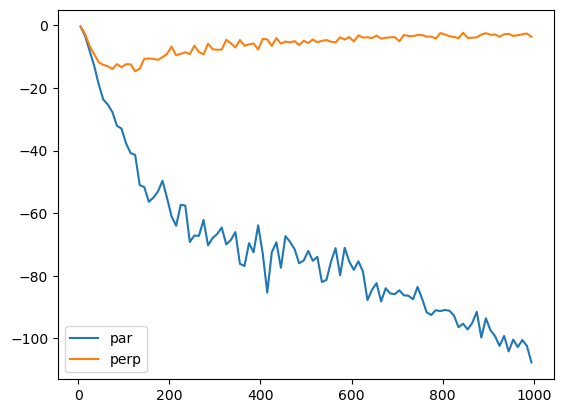

In [488]:
for n in names:
    plt.plot(Ls, betas[n]*Ls**4*1e10, label = n)
plt.legend()

In [489]:
integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi]])
nitn, neval = 10, 1e3

def SfTT(l1v, l2v, l1n, l2n):
    return np.dot(l1v+l2v, l1v)*lTT(l1n)+np.dot(l1v+l2v, l2v)*lTT(l2n)

def SftotTT(l):
    return tTT(l)

def Sg(lv, Lv):
    l1v, l2v = lv, Lv-lv
    l1n, l2n = np.linalg.norm(l1v), np.linalg.norm(l2v)
    return SfTT(l1v, l2v, l1n, l2n)/(2*SftotTT(l1n)*SftotTT(l2n))

S = []
for L in Ls:
    Lvec = np.array([L, 0])
    def integrand(x):
        l, theta = x
        ldotL = L*l*np.cos(theta)
        result = Sg(np.array([l*np.cos(theta), l*np.sin(theta)]), Lvec)*uTT(l)*ldotL*l
        return result
    result = integ(integrand, nitn = nitn, neval = neval)
    S.append(result.mean)
S = np.array(S)/(2*np.pi)**2


In [490]:
AL = np.interp(Ls, cents, AL1D)

In [491]:
ALnew = np.interp(Ls, cents, expr1D**-1)

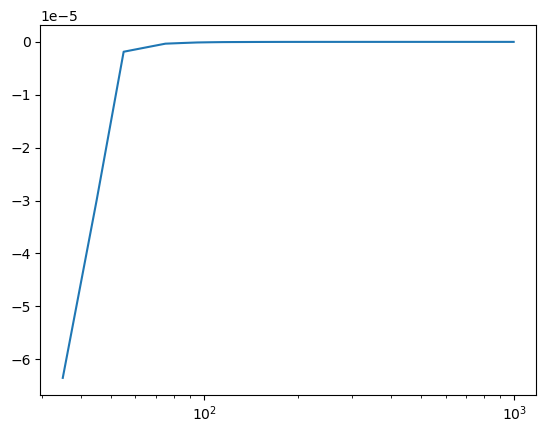

In [494]:
ppinterp = np.interp(Ls, l, ddlensing)
NC1term = -4*ALnew**2*S*np.sum([betas[n]*Rs[n] for n in names], axis = 0)
plt.plot(Ls, NC1term/ppinterp)
plt.xscale('log')

In [493]:
def dot_(a, b):
    return np.einsum('ab, ab -> b', a, b)

def dot(a, b):
    return a[0, :]*b[0, :]+a[1, :]*b[1, :]

    
def fTTbatch(l1v, l2v, l1n, l2n):
    return dot(l1v+l2v, l1v)*lTT(l1n)+dot(l1v+l2v, l2v)*lTT(l2n)

def ftotTTfTTbatch(l):
    return tTT(l)

def gfTTbatch(lv, Lv, l1n, l2n):
    l1v, l2v = lv, Lv-lv
    return fTTbatch(l1v, l2v, l1n, l2n)/(2*ftotTTfTTbatch(l1n)*ftotTTfTTbatch(l2n))

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline
lmin=2

cTTobs = InterpolatedUnivariateSpline(ls,CT[2:lmax+1,0]/ls/(ls+1)*2*np.pi + noise)
cTTgrad_obs = InterpolatedUnivariateSpline(ls,clgrad[2:lmax+1,0]/ls/(ls+1)*2*np.pi + noise)

def get_response(lmaxTT = 4000):
    Nzero = np.zeros(Ls.shape)
    resp = np.zeros(Ls.shape)
    resp_grad = np.zeros(Ls.shape)
    resp_gradgrad = np.zeros(Ls.shape)
    resp_gradgradgrad = np.zeros(Ls.shape)    
    dL = 5
    for ix, L in enumerate(Ls):
        Lsamp=  np.arange(lmin,lmaxTT+1, dL, dtype=np.float64)
        resp_L = np.zeros(Lsamp.shape)
        resp_grad_L = np.zeros(Lsamp.shape)
        resp_gradgrad_L = np.zeros(Lsamp.shape)
        resp_gradgradgrad_L = np.zeros(Lsamp.shape)        
        for i, l in enumerate(Lsamp):
            nphi= max(32,2*int(l)+1) 
            nphi=min(nphi,128) 
            dphi=(2*np.pi/nphi)
            phi = np.linspace(0,2*np.pi, nphi, endpoint =False)
            cos = np.cos(phi)
            weight = dphi*l/(2*np.pi)**2 
            l3 = np.sqrt(L**2+l**2 -2*L*l*cos)

            response =((-L*l*cos + L**2)*cTT(l3) + (L*l*cos)*cTT(l))  
            response_grad =((-L*l*cos + L**2)*cTTgrad(l3) + (L*l*cos)*cTTgrad(l))
            
            filter = 1/(cTTobs(l)*cTTobs(l3))
            filter[l3<lmin]=0
            filter[l3>lmaxTT]=0
            
            filter_grad = 1/(cTTgrad_obs(l)*cTTgrad_obs(l3))            
            #filter_grad = 1/(cTTobs(l)*cTTobs(l3))
            filter_grad[l3<lmin]=0
            filter_grad[l<lmin]=0            
            filter_grad[l3>lmaxTT]=0
            
            g = response*filter
            g_grad = response*filter_grad             
            g_gradgrad = response_grad*filter
            
            resp_L[i] = np.dot(g,response)*weight   
            resp_grad_L[i] = np.dot(g,response_grad)*weight   
            resp_gradgrad_L[i] = np.dot(g_grad,response_grad)*weight  
            resp_gradgradgrad_L[i] = np.dot(g_gradgrad,response_grad)*weight            
            
        resp[ix] = np.sum(InterpolatedUnivariateSpline(Lsamp, resp_L,ext=1)(np.arange(Lsamp[0],Lsamp[-1])))
        resp_grad[ix] = np.sum(InterpolatedUnivariateSpline(Lsamp, resp_grad_L,ext=1)(np.arange(Lsamp[0],Lsamp[-1])))
        resp_gradgrad[ix] = np.sum(InterpolatedUnivariateSpline(Lsamp, resp_gradgrad_L,ext=1)(np.arange(Lsamp[0],Lsamp[-1])))
        resp_gradgradgrad[ix] = np.sum(InterpolatedUnivariateSpline(Lsamp, resp_gradgradgrad_L,ext=1)(np.arange(Lsamp[0],Lsamp[-1])))        
        
    return resp, resp_grad, resp_gradgrad,resp_gradgradgrad
lmaxTT=lmax
print '%s lmaxTT = %d lmax =%d'%(experiment,lmaxTT,lmax),lmaxTT,lmax
#resp, resp_grad = get_response(lmaxTT)
resp, resp_grad, resp_gradgrad, resp_gradgradgrad = get_response(lmaxTT=4000)


In [426]:
integ = vegas.Integrator([[lmin, lmax], [lmin, lmax], [0, 2*np.pi], [0, 2*np.pi]])
nitn, neval = 10, 1e2

NA1 = []
for L in Ls:

    @vegas.batchintegrand
    def integrand(x):
        l, l1, theta, theta1 = x.T
        lv, l1v = np.array([l*np.cos(theta), l*np.sin(theta)]), np.array([l1*np.cos(theta1), l1*np.sin(theta1)])
        Lvec = np.c_[np.ones_like(l)*L, np.zeros_like(l)].T
        l1ml = l1v-lv
        l1mln = np.linalg.norm(l1ml, axis = 0)
        l1mldotl = (l1ml[0, :]*lv[0, :]+l1ml[1, :]*lv[1, :])/(l1mln*l)
        Lmlv = Lvec-lv
        Lmln = np.linalg.norm(Lmlv, axis = 0)

        Lmldotl1ml = (Lmlv[0, :]*l1ml[0, :]+Lmlv[1, :]*l1ml[1, :])/(Lmln*l1mln)
        temp = uTT(l1mln)

        l2n = np.linalg.norm(Lvec-l1v, axis = 0)
        product = l1mldotl*Lmldotl1ml*temp*gfTTbatch(l1v, Lvec, l1, l2n)

        Lml = np.linalg.norm(Lmlv)
        angle12 = get_angle_12(l, -L, Lml)
        angle13 = get_angle_12(l, Lml, -L)
        angle23 = get_angle_12(-L, Lml, l)
        angle12, angle13, angle23 = np.nan_to_num(angle12), np.nan_to_num(angle13), np.nan_to_num(angle23)
        factortophi = -8/(l*L*Lml)**2
        return factortophi*integrate_bispectrum_kkk(l, Lml, L, angle12, angle13, angle23, model = model)*product*l*l1
    result = integ(integrand, nitn = nitn, neval = neval)
    NA1 += [result.mean]
NA1 = np.array(NA1)/(2*np.pi)**4

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_55200/135368975.py:12: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(term)


In [436]:
integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi], [lmin, lmax], [0, 2*np.pi]])
nitn, neval = 10, 1e2
 
NC1 = []
for L in Ls:

    @vegas.batchintegrand
    def integrand(x):
        l1, theta1, l, theta = x.T
        lv, l1v = np.array([l*np.cos(theta), l*np.sin(theta)]), np.array([l1*np.cos(theta1), l1*np.sin(theta1)])
        Lvec = np.c_[np.ones_like(l)*L, np.zeros_like(l)].T

        l1dotl = (l1v[0, :]*lv[0, :]+l1v[1, :]*lv[1, :])/(l1*l)

        Lmlv = Lvec-lv
        Lmln = np.linalg.norm(Lmlv, axis = 0)

        l1dotLml = (Lmlv[0, :]*l1v[0, :]+Lmlv[1, :]*l1v[1, :])/(Lmln*l1)

        l2n = np.linalg.norm(Lvec-l1v, axis = 0)
        product = l1dotl*l1dotLml*uTT(l1)*gfTTbatch(l1v, Lvec, l1, l2n)

        Lml = Lmln
        angle12 = get_angle_12(l, Lml, -L)
        angle13 = get_angle_12(l, -L, Lml)
        angle23 = get_angle_12(-L, Lml, l)
        angle12, angle13, angle23 = np.nan_to_num(angle12), np.nan_to_num(angle13), np.nan_to_num(angle23)
        angle12, angle13, angle23 = np.pi/3, np.pi/3, np.pi/3
        factortophi = -8/(l*L*Lml)**2
        return factortophi*integrate_bispectrum_kkk(l, Lml, L, angle12, angle13, angle23, model = model)*product*l*l1
    result = integ(integrand, nitn = nitn, neval = neval)
    NC1 += [result.mean]
NC1 = np.array(NC1)/(2*np.pi)**4

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_55200/135368975.py:12: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(term)


KeyboardInterrupt: 

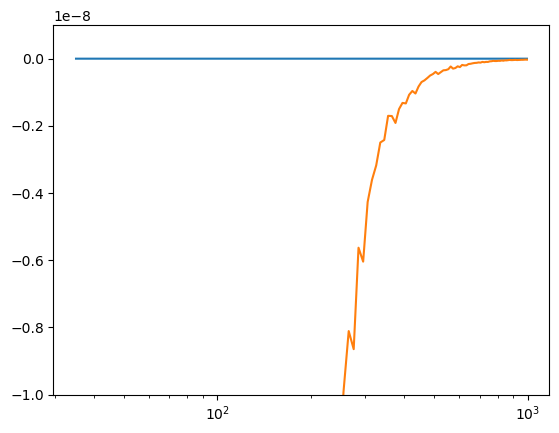

In [ ]:
NC1term_alt = 4*ALnew**2*S*NC1
plt.plot(Ls, NC1term_alt/ppinterp)
plt.plot(Ls, NC1term/ppinterp)
plt.ylim(-1e-8, 1e-9)
plt.xscale('log')

In [358]:
NA1term = -4*ALnew**2*S*NA1

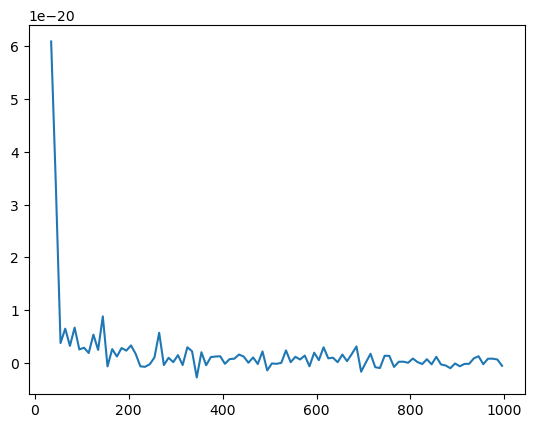

In [359]:
plt.plot(Ls, NA1term*Ls**4/(2*np.pi))